### FLORIS CALIBRATION

In [39]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable


import numpy as np 
import pathlib
import pandas as pd
import scipy as sp
import pickle
import sys

import floris.layout_visualization as layoutviz
from floris import (
    FlorisModel,
    TimeSeries,
    WindRose,
    WindTIRose,
)
from floris.flow_visualization import visualize_cut_plane

library_path = '../'
if library_path not in sys.path:
    sys.path.append(library_path)
import calibrate_floris as cf

import floris
print(f"The source file for the floris library is located at: {floris.__file__}")

The source file for the floris library is located at: /projects/wind_uq/gyalla/src/python/TCF_03_24_2025/lib/python3.12/site-packages/floris/__init__.py


### SETUP FLORIS CASES 

In [40]:
#Define list of cases 
cases = [
    "MedWS_LowTI_Baseline_6D_45",
    "MedWS_LowTI_Baseline_5D_45",
]

#Specify setup files to be generated for each case
setup_files = {}
setup_files[cases[0]] = 'MedWS_LowTI_Baseline_6D_45_emgauss.yaml'
setup_files[cases[1]] = 'MedWS_LowTI_Baseline_5D_45_emgauss.yaml'

#Specify original version of floris yaml that will be modified
input_setup_file = "emgauss_example.yaml"

#Specify shared parameters between each case
wind_speed = 9.01
setup_params  = {
    'flow_field.wind_speeds': [wind_speed,],
    'flow_field.air_density': 1.2456,
    'flow_field.wind_directions': [225,],
    'flow_field.turbulence_intensities': [0.0309,],
    'flow_field.wind_veer': 8.94,
    'flow_field.wind_shear': 0.16,
    'farm.turbine_type': ['iea_15MW',],
    'farm.turbine_library_path': './turbine_library/'
}

layouts  = {}

In [41]:
#Layout for baseline 6D 45
T00_base_position               = [1963.53247, 4000.0, 0.0]
T01_base_position               = [2981.766235, 2981.766235, 0.0]
T02_base_position               = [4000.0, 1963.53247, 0.0]
T03_base_position               = [2981.766235, 5018.233765, 0.0]
T04_base_position               = [4000.0, 4000.0, 0.0]
T05_base_position               = [5018.233765, 2981.766235, 0.0]
T06_base_position               = [4000.0 ,6036.46753, 0.0]
T07_base_position               = [5018.233765, 5018.233765, 0.0]
T08_base_position               = [6036.46753, 4000.0, 0.0]

layout_x  = [T00_base_position[0],T01_base_position[0],T02_base_position[0],T03_base_position[0],T04_base_position[0],T05_base_position[0],T06_base_position[0],T07_base_position[0],T08_base_position[0]]
layout_y  = [T00_base_position[1],T01_base_position[1],T02_base_position[1],T03_base_position[1],T04_base_position[1],T05_base_position[1],T06_base_position[1],T07_base_position[1],T08_base_position[1]]
layouts[cases[0]] = (layout_x,layout_y)

In [42]:
#layout for baseline 5D 45
T00_base_position               = [2302.943725, 4000.0, 0.0]
T01_base_position               = [3151.471863, 3151.471863, 0.0]
T02_base_position               = [4000.0, 2302.943725, 0.0]
T03_base_position               = [3151.471863, 4848.528137, 0.0]
T04_base_position               = [4000.0, 4000.0, 0.0]
T05_base_position               = [4848.528137, 3151.471863, 0.0]
T06_base_position               = [4000.0, 5697.056275, 0.0]
T07_base_position               = [4848.528137, 4848.528137, 0.0]
T08_base_position               = [5697.056275, 4000.0, 0.0]

layout_x  = [T00_base_position[0],T01_base_position[0],T02_base_position[0],T03_base_position[0],T04_base_position[0],T05_base_position[0],T06_base_position[0],T07_base_position[0],T08_base_position[0]]
layout_y  = [T00_base_position[1],T01_base_position[1],T02_base_position[1],T03_base_position[1],T04_base_position[1],T05_base_position[1],T06_base_position[1],T07_base_position[1],T08_base_position[1]]
layouts[cases[1]] = (layout_x,layout_y)

In [43]:

floris_models = {}
for case in cases:
    setup_params["farm.layout_x"] = layouts[case][0]
    setup_params["farm.layout_y"] = layouts[case][1]
    cf.setup_floris_yaml(input_setup_file,setup_params,output_file=setup_files[case])
    floris_model = FlorisModel(setup_files[case],)
    floris_models[case] = floris_model
    print("Setup floris model for " + case + " with configuration file: ", floris_model.configuration)


Setup floris model for MedWS_LowTI_Baseline_6D_45 with configuration file:  MedWS_LowTI_Baseline_6D_45_emgauss.yaml
Setup floris model for MedWS_LowTI_Baseline_5D_45 with configuration file:  MedWS_LowTI_Baseline_5D_45_emgauss.yaml


### CALIBRATION

In [44]:
#initial values for calibration parameters
calibration_params = {
        'wake.wake_velocity_parameters.empirical_gauss.mixing_gain_velocity': 3.3,
        'wake.wake_turbulence_parameters.wake_induced_mixing.atmospheric_ti_gain': 0.01,
        'wake.wake_velocity_parameters.empirical_gauss.wake_expansion_rates': [0.003,0.02,1.00],
        'wake.wake_velocity_parameters.empirical_gauss.breakpoints_D': [4,11,],
        'flow_field.wind_speeds': [9.0,],

}

#bounds for each parameter
calibration_bounds = {
    'wake.wake_velocity_parameters.empirical_gauss.mixing_gain_velocity': (0,10),
    'wake.wake_turbulence_parameters.wake_induced_mixing.atmospheric_ti_gain': (0.0,0.05),
    'wake.wake_velocity_parameters.empirical_gauss.wake_expansion_rates': [(0.0,1.0),(0.0,1.0),(0.0,3.0)],
    'wake.wake_velocity_parameters.empirical_gauss.breakpoints_D': [(0,20),(1,20)],
    'flow_field.wind_speeds': (0,20),
}

target_data = {}
target_data[cases[0]] = ('turbine_power','./LES_data/MedWS_LowTI_Baseline_6D_45.csv')
target_data[cases[1]] = ('turbine_power','./LES_data/MedWS_LowTI_Baseline_5D_45.csv')

In [45]:
solver = cf.FLORIS_Optimizer(floris_models,calibration_params,target_data,calibration_bounds)

In [46]:

MLE=solver.optimize(maxiter = 100,savecsv='baseline_cost_function.csv')
print(MLE)

cost function:  4938689.057629529 , iteration:  1
cost function:  4938689.052430325 , iteration:  2
cost function:  4938688.137771367 , iteration:  3
cost function:  4938683.143237486 , iteration:  4
cost function:  4938685.911908882 , iteration:  5
cost function:  4938689.058568265 , iteration:  6
cost function:  4938689.082764281 , iteration:  7
cost function:  4938689.056596418 , iteration:  8
cost function:  4938689.118417436 , iteration:  9
cost function:  292806273.0324924 , iteration:  10
cost function:  292806273.0324924 , iteration:  11
cost function:  292806273.0324924 , iteration:  12
cost function:  292806273.0324924 , iteration:  13
cost function:  292806273.0324924 , iteration:  14
cost function:  292806273.0324924 , iteration:  15
cost function:  292806273.0324924 , iteration:  16
cost function:  292806273.0324924 , iteration:  17
cost function:  292806273.0324924 , iteration:  18
cost function:  50429745.5818017 , iteration:  19
cost function:  50429745.58197884 , itera

In [47]:
print(MLE)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 78450.1423937762
        x: [ 2.616e+00  2.985e-02  1.079e-02  3.438e-02  6.097e-01
             3.980e+00  1.159e+01  8.765e+00]
      nit: 42
      jac: [-5.844e+03  1.568e+05  2.178e+06  8.368e+05  4.459e+04
            -1.291e+04 -5.624e+04  1.278e+05]
     nfev: 495
     njev: 55
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>


In [55]:
wind_speed_factor = MLE.x[-1]/wind_speed
print(wind_speed_factor)

0.9728408350292002


                0
0    4.938689e+06
1    4.938689e+06
2    4.938688e+06
3    4.938683e+06
4    4.938686e+06
..            ...
490  7.845015e+04
491  7.845014e+04
492  7.845014e+04
493  7.845014e+04
494  7.845014e+04

[495 rows x 1 columns]


<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_130961/234564201.py:20: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mathcal{J} \; / \; \mathcal{J}_0$',fontsize=fsize)


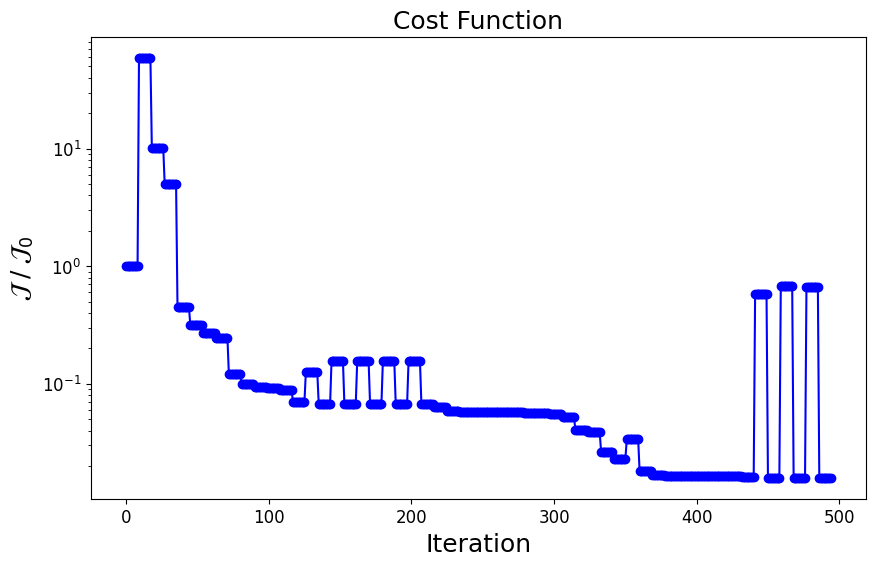

In [49]:
# Function to load CSV and plot values
def load_and_plot_csv(filename):
    fsize =18
    # Load the CSV file into a DataFrame
    data = pd.read_csv(filename, header=None)  # Use header=None since there are no headers
    print(data)

    # Extract the values from the DataFrame
    values = data.values  # Get the first row as a NumPy array
    values = values / values[0]

    # Create an index array
    indices = range(len(values))

    # Plot the values as a function of index
    plt.figure(figsize=(10, 6))
    plt.semilogy(indices, values, marker='o', linestyle='-', color='b')
    plt.title('Cost Function',fontsize=fsize)
    plt.xlabel('Iteration',fontsize=fsize)
    plt.ylabel('$\mathcal{J} \; / \; \mathcal{J}_0$',fontsize=fsize)
    #plt.ylim(0,2.0)
    #plt.xticks(indices)  # Set x-ticks to show all indices
    plt.tick_params(axis='x', labelsize=12)  # Change x tick label size
    plt.tick_params(axis='y', labelsize=12)  # Change y tick label size
    plt.show()

# Specify the filename
filename = 'baseline_cost_function.csv'
# Call the function to load and plot the CSV data
load_and_plot_csv(filename)

### Run calibrated model

In [50]:
floris_models = {}
for case in cases:
    floris_model = FlorisModel(setup_files[case])
    floris_models[case] = floris_model
    print("Setup floris model for " + case + " with configuration file: ", floris_model.configuration)


Setup floris model for MedWS_LowTI_Baseline_6D_45 with configuration file:  MedWS_LowTI_Baseline_6D_45_emgauss.yaml
Setup floris model for MedWS_LowTI_Baseline_5D_45 with configuration file:  MedWS_LowTI_Baseline_5D_45_emgauss.yaml


In [51]:
turbine_powers = {}
for case in cases:
    floris_model = floris_models[case]
    floris_model.run()
    turbine_powers[case] = floris_model.get_turbine_powers()/1000


In [52]:
LES_dirs = [
    target_data[cases[0]][1],
    target_data[cases[1]][1],
]

LES_windfarm_names = [\
    'LES_' + cases[0],
    'LES_' + cases[1],
]

floris_labels = {}
floris_labels[cases[0]] = 'FLORIS, Baseline, 6D, 45'
floris_labels[cases[1]] = 'FLORIS, Baseline, 5D, 45'

LES_labels = {}
LES_labels['LES_' + cases[0]] = 'LES, Baseline, 6D, 45'
LES_labels['LES_' + cases[1]] = 'LES, Baseline, 5D, 45'

turbine_names = ['T0','T1','T2','T3','T4','T5','T6','T7','T8']
LES_turbine_data_mean  = {}
for farmiter,farm in enumerate(LES_windfarm_names):
    LES_turbine_data_mean[farm] = {}
    df = pd.read_csv(LES_dirs[farmiter],header=None)
    for turbiter , turbine_name in enumerate(turbine_names):
        LES_turbine_data_mean[farm][turbine_name] = df[turbiter][0]

FLORIS_turbine_data_mean  = {}
for case in cases:
    FLORIS_turbine_data_mean[case] = {}
    for turbiter , turbine_name in enumerate(turbine_names):
        FLORIS_turbine_data_mean[case][turbine_name] = turbine_powers[case][0,turbiter]

windfarm_names = cases+LES_windfarm_names
turbine_data_mean  = {}
case_labels = {}
for name in windfarm_names:
    turbine_data_mean[name] = {}
    for turbiter , turbine_name in enumerate(turbine_names):
        if name in cases:
            turbine_data_mean[name][turbine_name] = FLORIS_turbine_data_mean[name][turbine_name]
            case_labels[name] = floris_labels[name]
        else:
            turbine_data_mean[name][turbine_name] = LES_turbine_data_mean[name][turbine_name]
            case_labels[name] = LES_labels[name]


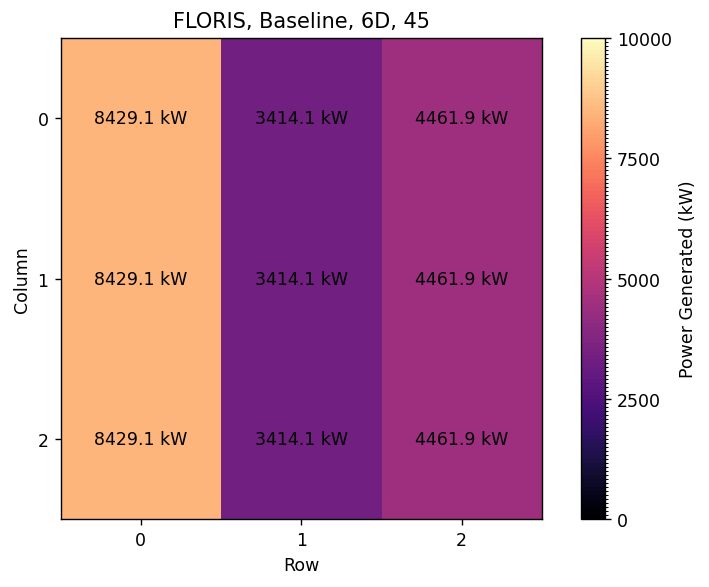

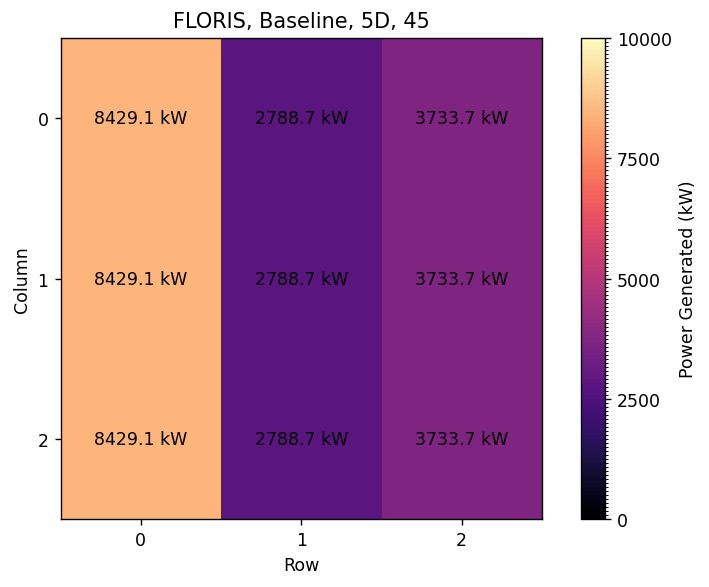

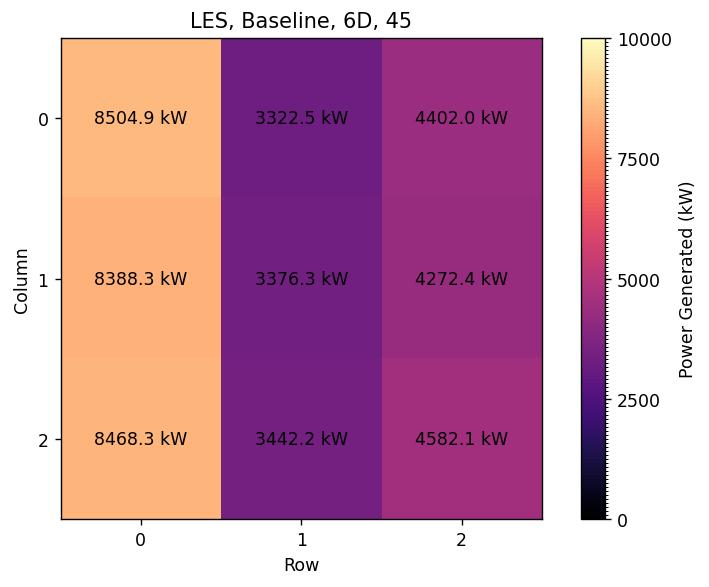

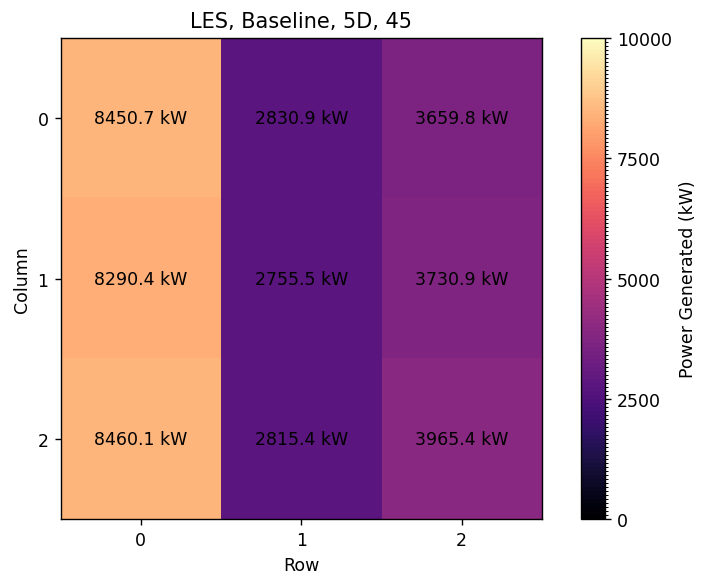

In [53]:
# Create the heatmap
for farmiter, farm in enumerate(windfarm_names):
    fig, ax = plt.subplots(figsize=(8,5),dpi=125)

    #col by row
    power_data  = np.zeros((3,3))

    titer = 0
    for row in range(3):
        for col in range(3):
            turbine_name = turbine_names[titer]
            power_data[col,row] = turbine_data_mean[farm][turbine_name]
            titer += 1
    import matplotlib.colors as mcolors

    levels = np.linspace(0,10000,121)
    cmap = plt.get_cmap('magma')
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
    cax = ax.imshow(power_data, cmap=cmap, norm=norm, interpolation='nearest')
    # Add text annotations with 1 decimal place and 'kW'
    for i in range(power_data.shape[0]):
        for j in range(power_data.shape[1]):
            ax.text(j, i, f'{power_data[i, j]:.1f} kW', ha='center', va='center', color='k')

    # Add a colorbar
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Power Generated (kW)')
    cticks = np.linspace(levels[0],levels[-1],5)
    cbar.set_ticks(cticks)

    # Set labels and title
    ax.set_xticks(np.arange(power_data.shape[1]))
    ax.set_yticks(np.arange(power_data.shape[0]))
    #ax.set_xticklabels(['Turbine 1', 'Turbine 2', 'Turbine 3'])
    #ax.set_yticklabels(['Row 1', 'Row 2', 'Row 3'])
    #ax.set_xlabel('Turbine')
    #ax.set_ylabel('Row')
    ax.set_xlabel('Row')
    ax.set_ylabel('Column')
    #ax.set_title('Generated Power by Turbine\n'+windfarm_names[farmiter])
    ax.set_title(case_labels[farm])

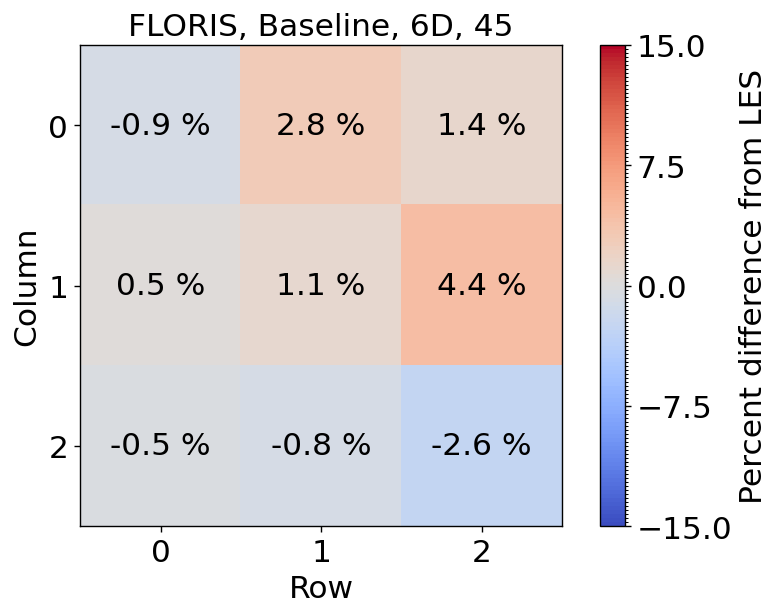

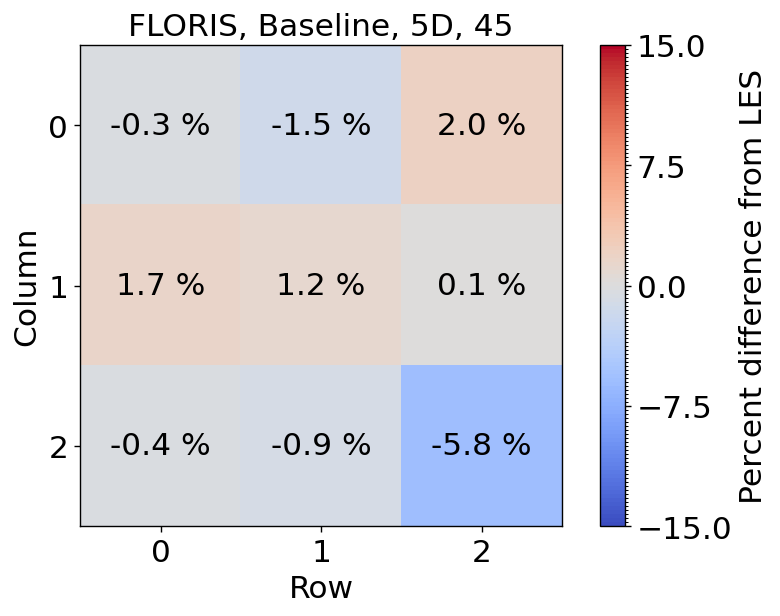

In [54]:
# Create the heatmap
power_data = {}
for farmiter, farm in enumerate(windfarm_names):

    #col by row
    power_data[farm]  = np.zeros((3,3))
    titer = 0
    for row in range(3):
        for col in range(3):
            turbine_name = turbine_names[titer]
            power_data[farm][col,row] = turbine_data_mean[farm][turbine_name]
            titer += 1

fsize = 18
for farmiter, farm in enumerate(cases):
    fig, ax = plt.subplots(figsize=(8,5),dpi=125)
    import matplotlib.colors as mcolors
    levels = np.linspace(-15,15,121)
    cmap = plt.get_cmap('coolwarm')
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
    LES_compare = power_data[LES_windfarm_names[farmiter]]
    val  = 100*(power_data[farm]-LES_compare)/LES_compare
    cax = ax.imshow(val, cmap=cmap, norm=norm, interpolation='nearest')
    # Add text annotations with 1 decimal place and 'kW'
    for i in range(val.shape[0]):
        for j in range(val.shape[1]):
            ax.text(j, i, f'{val[i,j]:.1f} %', ha='center', va='center', color='k',fontsize=fsize)

    # Add a colorbar
    cbar = fig.colorbar(cax, ax=ax)
    #cbar.set_label('Power Generated (kW)')
    cbar.set_label('Percent difference from LES',fontsize=fsize)
    cticks = np.linspace(levels[0],levels[-1],5)
    cbar.set_ticks(cticks)
    # Set font size for axis tick labels
    ax.tick_params(axis='both', labelsize=fsize)  # Change 14 to your desired font size

    # Set font size for colorbar tick labels
    cbar.ax.tick_params(labelsize=fsize)  # Change 12 to your desired font size

    # Set labels and title
    ax.set_xticks(np.arange(power_data[farm].shape[1]))
    ax.set_yticks(np.arange(power_data[farm].shape[0]))
    ax.set_ylabel('Column',fontsize=fsize)
    ax.set_xlabel('Row',fontsize=fsize)
    ax.set_title(case_labels[farm],fontsize=fsize)